# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [26]:
import numpy as np
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [10]:
CARREG_COORDS = {"Easting": 282903, "Northing": 288549}
RAIN_COL = "rain_mm"

## Load CEH-GEAR

In [11]:
ceh_carreg = xr.open_dataset('cehgear_data/ceh_1km_carreg3by3_19760101_20100101.nc')
assert ceh_carreg['northing'].size == 3, "Should be 3 by 3 km grid box"
ceh_carreg = ceh_carreg.rename({'Rainfall': RAIN_COL})
ceh_carreg

<xarray.Dataset> Size: 563kB
Dimensions:   (time: 12784, northing: 3, easting: 3)
Coordinates:
  * northing  (northing) float32 12B 2.88e+05 2.89e+05 2.9e+05
  * easting   (easting) float32 12B 2.82e+05 2.83e+05 2.84e+05
  * time      (time) datetime64[ns] 102kB 1976-01-01 1976-01-02 ... 2010-12-31
Data variables:
    rain_mm   (time, northing, easting) float32 460kB ...

In [12]:
## Compute rainfall mean over Carreg-wen (3 * 3 km)
ceh_carreg_mean = ceh_carreg[RAIN_COL].mean(('easting', 'northing'))
ceh_carreg_mean = pl.from_pandas(ceh_carreg_mean.to_dataframe().reset_index()) ## convert to polars
ceh_carreg_mean = ceh_carreg_mean.rename({RAIN_COL: f'{RAIN_COL}_mean'})

#  Closest 1km grid cell to gauge
ceh_carreg_1cell = ceh_carreg.sel(easting=283000, northing=289000)
ceh_carreg_1cell = ceh_carreg_1cell[RAIN_COL].drop_vars(('northing', 'easting')) ## drop unnecessary vars
ceh_carreg_1cell = pl.from_pandas(ceh_carreg_1cell.to_dataframe().reset_index()) ##convert to polars
ceh_carreg_1cell = ceh_carreg_1cell.rename({RAIN_COL: f'{RAIN_COL}_1cell'})

In [28]:
## join data together
ceh_carreg_all = ceh_carreg_mean.join(ceh_carreg_1cell, on='time')

## overwrite value to be 9 am NOTE: messy but necessary for how the data has been stored
ceh_carreg_all = ceh_carreg_all.with_columns(
    pl.datetime(
        pl.col("time").dt.year(),
        pl.col("time").dt.month(),
        pl.col("time").dt.day(),
        9,
        pl.col("time").dt.minute(),
        pl.col("time").dt.second(),
    ).alias('time')
)
ceh_carreg_all

time,rain_mm_mean,rain_mm_1cell
datetime[μs],f32,f32
1976-01-01 09:00:00,50.080555,50.825001
1976-01-02 09:00:00,31.31111,31.775
1976-01-03 09:00:00,4.427778,4.35
1976-01-04 09:00:00,36.216667,36.875
1976-01-05 09:00:00,8.338889,8.4
…,…,…
2010-12-27 09:00:00,24.827778,25.275
2010-12-28 09:00:00,7.930555,8.075
2010-12-29 09:00:00,0.477778,0.475


## Load HadUK-Grid

In [13]:
haduk_carreg = xr.open_mfdataset(['hadukgrid_data/hadukgrid_1km_carreg3by3_19760101_19920831.nc',\
                 'hadukgrid_data/hadukgrid_1km_carreg3by3_19920901_20091231.nc'])
assert haduk_carreg['projection_x_coordinate'].size == 3, "Should be 3 by 3 km grid box"
haduk_carreg = haduk_carreg.rename({'rainfall': RAIN_COL})
haduk_carreg

<xarray.Dataset> Size: 2MB
Dimensions:                       (time: 12419, projection_y_coordinate: 3,
                                   projection_x_coordinate: 3, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 99kB 1976-01-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float64 24B 2.875...
  * projection_x_coordinate       (projection_x_coordinate) float64 24B 2.815...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 72B dask.array<chunksize=(3, 3), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 72B dask.array<chunksize=(3, 3), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rain_mm                       (time, projection_y_coordinate, projection_x_coordinate) float64 894kB dask.array<chunksize=(6088, 3, 3), meta=np.ndarray>
    transverse_mercator           (time) int32 50kB dask.array<chunksize=(6088,), meta=np.ndarray>
    time_bnds                     (time, bnds) datetime64[ns] 199kB dask.array<chunksize=(6088, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 596kB dask.array<chunksize=(6088, 3, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 596kB dask.array<chunksize=(6088, 3, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T13:12:49
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

In [14]:
## Compute rainfall mean over Carreg-wen (3 * 3 km)
haduk_carreg_mean = haduk_carreg[RAIN_COL].mean(('projection_x_coordinate', 'projection_y_coordinate'))
haduk_carreg_mean = pl.from_pandas(haduk_carreg_mean.to_dataframe().reset_index()) ## convert to polars
haduk_carreg_mean = haduk_carreg_mean.rename({RAIN_COL: f'{RAIN_COL}_mean'})

#  Closest 1km grid cell to gauge
haduk_carreg_1cell = haduk_carreg.sel(projection_x_coordinate=282500+0, projection_y_coordinate=288500+0)
haduk_carreg_1cell = haduk_carreg_1cell[RAIN_COL].drop_vars(('projection_y_coordinate', 'projection_x_coordinate', 'latitude', 'longitude')) ## drop unnecessary vars
haduk_carreg_1cell = pl.from_pandas(haduk_carreg_1cell.to_dataframe().reset_index()) ##convert to polars
haduk_carreg_1cell = haduk_carreg_1cell.rename({RAIN_COL: f'{RAIN_COL}_1cell'})

In [15]:
## join data together
haduk_carreg_all = haduk_carreg_mean.join(haduk_carreg_1cell, on='time')

## overwrite value to be 9 am NOTE: messy but necessary for how the data has been stored
haduk_carreg_all = haduk_carreg_all.with_columns(
    pl.datetime(
        pl.col("time").dt.year(),
        pl.col("time").dt.month(),
        pl.col("time").dt.day(),
        9,
        pl.col("time").dt.minute(),
        pl.col("time").dt.second(),
    ).alias('time')
)
haduk_carreg_all

time,rain_mm_mean,rain_mm_1cell
datetime[μs],f64,f64
1976-01-01 09:00:00,53.82373,55.60586
1976-01-02 09:00:00,33.190642,34.252948
1976-01-03 09:00:00,4.558701,4.645649
1976-01-04 09:00:00,40.954625,42.494596
1976-01-05 09:00:00,9.248094,9.494617
…,…,…
2009-12-27 09:00:00,3.978755,4.08665
2009-12-28 09:00:00,0.647344,0.664587
2009-12-29 09:00:00,22.786502,23.384517


## Load Gauge data

In [16]:
## Load gauge data
gauge_carreg = pl.read_csv('gauge_data/plynlimon-jwk-2024-infilled_carreg_rf.csv', skip_rows=13,\
                          try_parse_dates=True, columns=[0, 1], new_columns=["time", f'{RAIN_COL}_gauge'])
gauge_carreg

time,rain_mm_gauge
datetime[μs],f64
1976-01-02 09:00:00,null
1976-01-03 09:00:00,0.5
1976-01-04 09:00:00,62.0
1976-01-05 09:00:00,12.5
1976-01-06 09:00:00,5.0
…,…
2010-12-27 09:00:00,0.0
2010-12-28 09:00:00,20.0
2010-12-29 09:00:00,1.5


## Join data together

In [40]:
carreg_rain_data

time,rain_mm_gauge,rain_mm_mean,rain_mm_1cell,rain_mm_meanhaduk,rain_mm_1cellhaduk
datetime[μs],f64,f32,f32,f64,f64
1976-01-02 09:00:00,null,31.31111,31.775,33.190642,34.252948
1976-01-03 09:00:00,0.5,4.427778,4.35,4.558701,4.645649
1976-01-04 09:00:00,62.0,36.216667,36.875,40.954625,42.494596
1976-01-05 09:00:00,12.5,8.338889,8.4,9.248094,9.494617
1976-01-06 09:00:00,5.0,1.963889,2.0,2.285885,2.469852
…,…,…,…,…,…
2009-12-27 09:00:00,7.0,2.388889,2.425,3.978755,4.08665
2009-12-28 09:00:00,1.0,0.280556,0.275,0.647344,0.664587
2009-12-29 09:00:00,0.0,19.666666,19.975,22.786502,23.384517


In [42]:
carreg_rain_data = gauge_carreg.join(ceh_carreg_all, on='time')
carreg_rain_data = carreg_rain_data.join(haduk_carreg_all, on='time', suffix='_haduk')
carreg_rain_data = carreg_rain_data.rename({f'{RAIN_COL}_mean': f'{RAIN_COL}_mean_cehgear',\
                    f'{RAIN_COL}_1cell': f'{RAIN_COL}_1cell_cehgear'})

carreg_rain_data = carreg_rain_data.select(['time', f'{RAIN_COL}_gauge',\
                    f'{RAIN_COL}_1cell_cehgear', f'{RAIN_COL}_mean_cehgear',\
                    f'{RAIN_COL}_1cell_haduk', f'{RAIN_COL}_mean_haduk']) # reorder
carreg_rain_data = carreg_rain_data.drop_nans() # drop_nans
carreg_rain_data.head(10)

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f32,f32,f64,f64
1976-01-03 09:00:00,0.5,4.35,4.427778,4.645649,4.558701
1976-01-04 09:00:00,62.0,36.875,36.216667,42.494596,40.954625
1976-01-05 09:00:00,12.5,8.4,8.338889,9.494617,9.248094
1976-01-06 09:00:00,5.0,2.0,1.963889,2.469852,2.285885
1976-01-07 09:00:00,3.5,0.65,0.677778,0.629355,0.769007
1976-01-08 09:00:00,2.25,2.075,2.019444,2.157339,1.928009
1976-01-09 09:00:00,34.25,37.625,37.05278,42.706809,39.518538
1976-01-10 09:00:00,24.0,17.875,17.288889,21.812376,20.099545
1976-01-11 09:00:00,0.5,0.2,0.205556,0.207547,0.219521


# 1 Analysis

In [51]:
carreg_annual_mean = carreg_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().mean())
carreg_annual_sum = carreg_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().sum())

carreg_annual_mean.head(10)

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f32,f32,f64,f64
1976-01-01 00:00:00,5.061676,4.636539,4.586386,5.052509,4.823164
1977-01-01 00:00:00,8.189726,7.436918,7.316461,7.894609,7.600082
1978-01-01 00:00:00,7.179452,6.659863,6.575396,7.211537,6.884219
1979-01-01 00:00:00,9.094521,7.715959,7.604308,8.194458,7.84368
1980-01-01 00:00:00,8.189891,7.180601,7.077489,7.725199,7.407256
1981-01-01 00:00:00,7.476301,7.690479,7.593798,8.25634,7.86266
1982-01-01 00:00:00,7.093425,6.980548,6.884057,7.318185,7.013691
1983-01-01 00:00:00,7.283562,7.836301,7.696225,8.223736,7.829762
1984-01-01 00:00:00,5.653005,6.049385,5.985132,6.587891,6.28271


In [ ]:
## calc_difference
def calc_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'] - data[col]

In [72]:
annual_data_dir = {'mean': carreg_annual_mean, 'sum': carreg_annual_sum}
stat_to_examine = 'sum'

In [74]:
stat_to_examine

'sum'

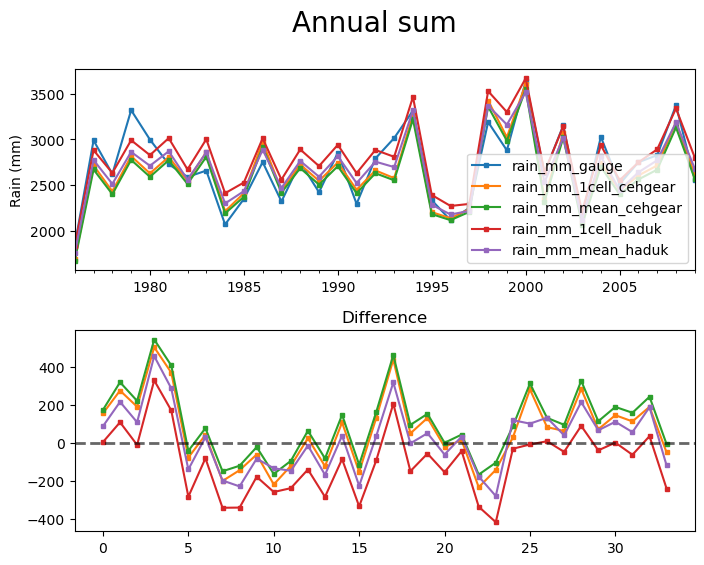

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
annual_data_dir[stat_to_examine].to_pandas().set_index('time').plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(annual_data_dir[stat_to_examine].columns[2:]):
    axes[1].plot(calc_difference_from_gauge(annual_data_dir[stat_to_examine], col), marker='s', markersize=3, label=col, color=f'C{1+ind}')
axes[1].set_title("Difference")
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')
plt.suptitle(f"Annual {stat_to_examine}", size=20)
plt.subplots_adjust(hspace=.3)

## double mass plot

In [85]:
carreg_rain_data_cumsum = carreg_rain_data.with_columns(
    pl.all().exclude("time").cum_sum()
)
carreg_rain_data_cumsum.tail()

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f32,f32,f64,f64
2009-12-27 09:00:00,92069.25,89917.859375,88604.140625,95371.906055,91353.209883
2009-12-28 09:00:00,92070.25,89918.132812,88604.421875,95372.570642,91353.857227
2009-12-29 09:00:00,92070.25,89938.109375,88624.085938,95395.955159,91376.64373
2009-12-30 09:00:00,92070.25,89951.0625,88636.796875,95409.865667,91390.215455
2009-12-31 09:00:00,92070.25,89951.0625,88636.796875,95409.910847,91390.258224


In [86]:
var_to_examine, data_to_examine = '1cell', 'cehgear'
x_var = f'{RAIN_COL}_1cell_haduk'
y_var = f'{RAIN_COL}_{var_to_examine}_{data_to_examine}'

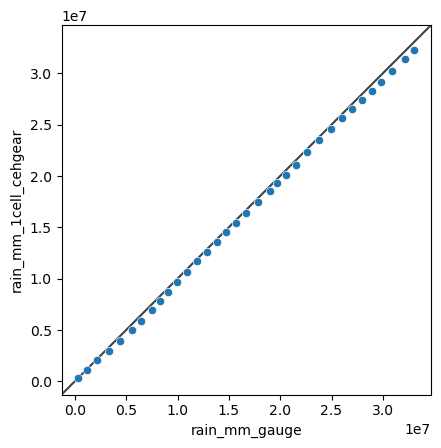

In [87]:
#  = carreg_rain_data_cumsum.group_by_dynamic('time', every='1y').agg(pl.all().sum())
data_to_plot = carreg_rain_data_cumsum.group_by_dynamic('time', every='12mo').agg(pl.all().sum())

fig, ax = plt.subplots(1)
sns.scatterplot(x='rain_mm_gauge', y=f'rain_mm_{var_to_examine}_{data_to_examine}', data=data_to_plot, ax=ax)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

## Spatial variation of HADUK

In [ ]:
dataset_dir = {'CEH-GEAR': ceh_carreg, 'HadUK-Grid': haduk_carreg}
dataset_to_examine = 'CEH-GEAR'

In [102]:
def plot_3by3_heatmap_mean_std(dataset, axes_row):
    dataset[RAIN_COL].mean('time').plot(cmap='Blues', ax=axes_row[0])
    axes_row[0].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[0].set_title('mean')

    dataset[RAIN_COL].std('time').plot(cmap='Purples', ax=axes_row[1])
    axes_row[1].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[1].set_title('stdev')

<xarray.DataArray 'northing' ()> Size: 8B
array(290000.)

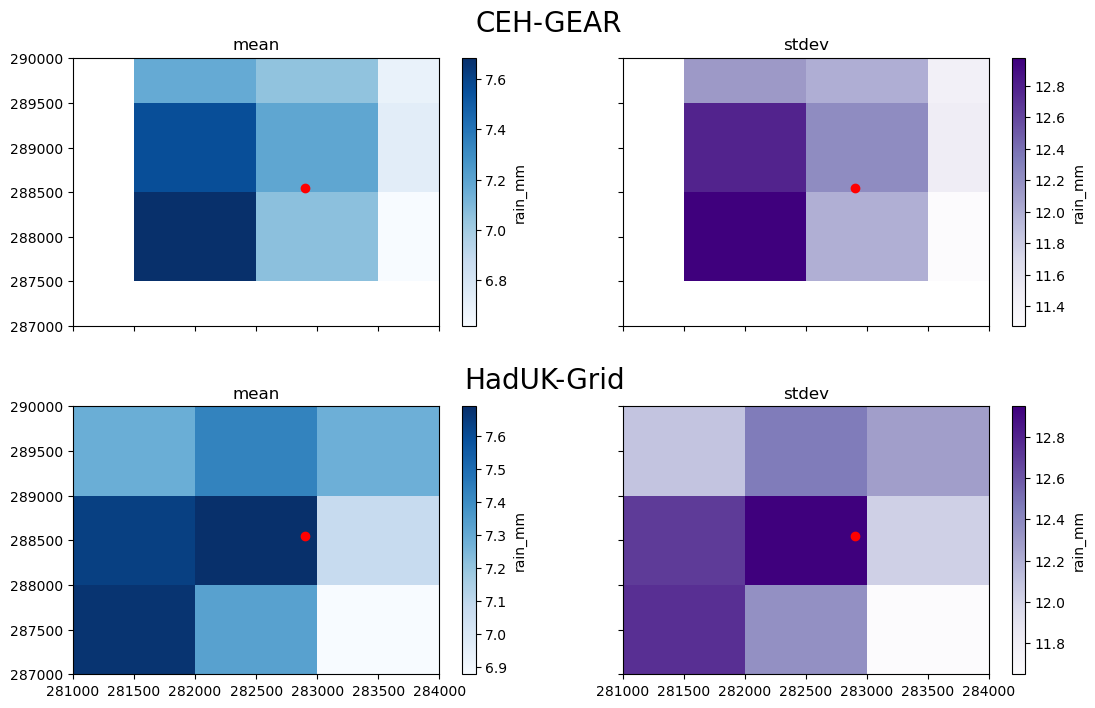

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=True, sharey=True)
plot_3by3_heatmap_mean_std(dataset_dir['CEH-GEAR'], axes_row=axes[0])
plot_3by3_heatmap_mean_std(dataset_dir['HadUK-Grid'], axes_row=axes[1])

for ax in axes.flatten():
    ax.set_xlabel(''); ax.set_ylabel('')

axes[0][0].text(s='CEH-GEAR', x=dataset_dir['CEH-GEAR']['easting'].max()+300,\
                              y=dataset_dir['CEH-GEAR']['northing'].max()+300,\
                                size=20)

axes[1][0].text(s='HadUK-Grid', x=dataset_dir['HadUK-Grid']['projection_x_coordinate'].max()+700,\
                              y=dataset_dir['HadUK-Grid']['projection_y_coordinate'].max()+700,\
                                size=20)

plt.subplots_adjust(hspace=.3)

## During flood events